
# Diagnostic Models for Precipitation

The following notebook will demonstrate how to use diagnostic models inside of Earth-2
MIP for transforming outputs of global weather models into different quantities of
interest. More information on diagnostics can be found in the [user guide](https://nvidia.github.io/earth2mip/userguide/diagnostic.html).

In summary this notebook will cover the following topics:

- Loading a built in diagnostic model for predicting total precipitation
- Combining the diagnostic model with a prognostic model using the DiangosticLooper


In [1]:
import datetime
import os
import dotenv

dotenv.load_dotenv()

False

## Loading Diagnostic Models
Loading diagnostic models is similar to prognostic models, but presently use a
slightly different API. In this example we will using the built in AFNO FourCast Net
to serve as the underlying prognostic model that will drive the time-ingration. The
:code:`PrecipitationAFNO` model will then be used to "post-process" the outputs of
this model to predict precipitation. The key API to load a diagnostic model is the
:code:`load_diagnostic(package)` function which takes a model package in. If you're
interested in using the built in model package (i.e. checkpoint), then the
:code:`load_package()` function can do this for you.



In [2]:
from modulus.distributed.manager import DistributedManager
from earth2mip.networks import get_model
from earth2mip.diagnostic import PrecipitationAFNO

device = DistributedManager().device

print("Loading FCN model")
model = get_model("e2mip://fcn", device=device)

print("Loading precipitation model")
package = PrecipitationAFNO.load_package()
diagnostic = PrecipitationAFNO.load_diagnostic(package)

Loading FCN model
Loading precipitation model


The next step is to wrap the prognostic model with the Diagnostic Time loop.
Essentially this adds the execution of the diagnostic model on top of the forecast
model iterator. This will add the total preciptation field (`tp`) to the output data
which can the be further processed.



In [3]:
from earth2mip.diagnostic import DiagnosticTimeLoop

model_diagnostic = DiagnosticTimeLoop(diagnostics=[diagnostic], model=model)

## Running Inference
With the diagnostic time loop created the final steps are to create the data source
and run inference. For this example we will use the CDS data source again. Its assumed
your CDS API key is already set up. Reference the [first example](https://nvidia.github.io/earth2mip/examples/01_ensemble_inference.html#set-up)
for additional information. We will use the basic inference workflow which returns a
Xarray dataset we will save to netCDF.

**TODO**: let user do rain forecast for Munich using GFS for next couple of days.



In [12]:
from earth2mip.inference_ensemble import run_basic_inference
from earth2mip.initial_conditions import cds, gfs, hdf5

print("Constructing initializer data source")
dat_source = 'gfs' # 'cds', 'gfs'

if dat_source == 'gfs':
    data_source = gfs.DataSource(model.in_channel_names)
    time = datetime.datetime(2024, 4, 9)
elif dat_source == 'cds':
    data_source = cds.DataSource(model.in_channel_names)
    time = datetime.datetime(2017, 8, 24, 12)
elif dat_source == 'hdf5':
    h5_folder = '/e2ws_data/era5_73var'
    data_source = hdf5.DataSource.from_path(
        root=h5_folder, channel_names=model.in_channel_names
    )
    time = datetime.datetime(2017, 8, 24, 12)

print("Running inference")
output_dir = "outputs/04_diagnostic_precip"
os.makedirs(output_dir, exist_ok=True)
ds = run_basic_inference(
    model_diagnostic,
    n=36,
    data_source=data_source,
    time=time,
)
ds.to_netcdf(os.path.join(output_dir, "precipitation_afno.nc"))
ds

Constructing initializer data source
Running inference


100%|███████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:06<00:00,  4.31it/s]


<xarray.DataArray (time: 37, history: 1, channel: 27, lat: 720, lon: 1440)>
array([[[[[ 7.23558855e+00,  7.23558855e+00,  7.22558832e+00, ...,
            7.25558853e+00,  7.24558878e+00,  7.24558878e+00],
          [ 7.14558840e+00,  7.14558840e+00,  7.14558840e+00, ...,
            7.15558815e+00,  7.15558815e+00,  7.15558815e+00],
          [ 6.87558842e+00,  6.87558842e+00,  6.87558842e+00, ...,
            6.87558842e+00,  6.87558842e+00,  6.87558842e+00],
          ...,
          [-1.66441178e+00, -1.64441144e+00, -1.63441157e+00, ...,
           -1.70441163e+00, -1.68441164e+00, -1.67441165e+00],
          [-1.46441162e+00, -1.45441163e+00, -1.43441164e+00, ...,
           -1.51441145e+00, -1.50441158e+00, -1.48441160e+00],
          [-7.74411678e-01, -7.54411638e-01, -7.34411597e-01, ...,
           -8.34411561e-01, -8.14411640e-01, -7.94411600e-01]],

         [[-1.20809567e+00, -1.23809576e+00, -1.26809573e+00, ...,
           -1.11809564e+00, -1.14809573e+00, -1.17809570e+00],
          [-7.48095691e-01, -7.78095663e-01, -8.08095634e-01, ...,
           -6.48095787e-01, -6.78095698e-01, -7.18095720e-01],
          [-4.58095729e-01, -4.98095691e-01, -5.28095722e-01, ...,
           -3.78095686e-01, -4.08095717e-01, -4.38095689e-01],
...
            2.07997528e+02,  2.07969269e+02,  2.07840561e+02],
          [ 2.12830109e+02,  2.12918625e+02,  2.12774231e+02, ...,
            2.08207550e+02,  2.08144516e+02,  2.08026505e+02],
          [ 2.13067093e+02,  2.13080368e+02,  2.13015488e+02, ...,
            2.08299850e+02,  2.08262253e+02,  2.08284653e+02]],

         [[ 1.96522956e-06,  3.26803911e-06,  3.78272284e-06, ...,
            7.53698316e-07,  1.19115225e-06,  1.61190508e-06],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  6.66426388e-07,  8.48060836e-07, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          ...,
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 1.11353870e-06,  1.16153831e-06,  7.54288408e-07, ...,
            1.53347244e-07,  0.00000000e+00,  1.46630407e-06]]]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.0 -89.25 -89.5 -89.75
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * channel  (channel) <U5 'u10m' 'v10m' 't2m' 'sp' ... 'z250' 't250' 'tp'
  * time     (time) datetime64[ns] 2024-04-09 2024-04-09T06:00:00 ... 2024-04-18
Dimensions without coordinates: history

## Post Processing
With inference complete we can do some post processing on our predictions. Lets first
visualize the total precipitation and total column water vapor for a few days.



This partiulcar date was selected for inference due to an atmopsheric river occuring
over the west coast of the United States. Lets plot the total precipitation that
occured over San Francisco.



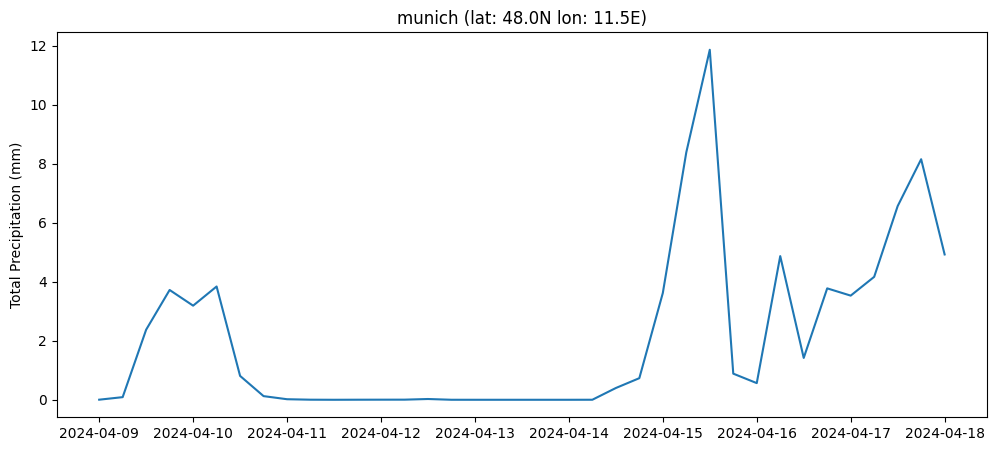

In [25]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

location = 'munich' # 'munich', 'san francisco'

if location == 'san francisco':
    loc_lat, loc_lon = 37.75, 237.5 # Lon is [0, 360]
elif location == 'munich':
    loc_lat, loc_lon = 48., 11.5
elif location == 'houston':
    loc_lat, loc_lon = 29.75, 264.75 # 84.75
else:
    raise ValueError(f'region {location} not implemented.')

plt.close("all")
# Open dataset from saved NetCDFs
ds = xr.open_dataarray(os.path.join(output_dir, "precipitation_afno.nc"))
tp = ds.sel(channel="tp", lat=loc_lat, lon=loc_lon)

plt.figure(figsize=(12,5))
plt.plot(pd.to_datetime(tp.coords["time"]), tp.values*1000)
plt.title(f"{location} (lat: {loc_lat}N lon: {loc_lon}E)")
plt.ylabel("Total Precipitation (mm)")
plt.savefig(f"{output_dir}/tp.png")

The land fall of the atmosphric river is very clear here, lets have a look at the
regional contour of the bay area to better understand the structure of this event.

In [29]:
plt.close("all")

# Open dataset from saved NetCDFs
ds = xr.open_dataarray(os.path.join(output_dir, "precipitation_afno.nc"))
nsteps = 4
proj = ccrs.AlbersEqualArea(central_latitude=loc_lat, central_longitude=loc_lon)
fig, ax = plt.subplots(
    1,
    nsteps,
    figsize=(20, 5),
    subplot_kw={"projection": proj},
    gridspec_kw={"wspace": 0.05, "hspace": 0.007},
)

for step in range(nsteps):
    i = step + 3
    tp = ds[i, 0].sel(channel="tp")

    ax[step].add_feature(cartopy.feature.OCEAN, zorder=0)
    ax[step].add_feature(cartopy.feature.LAND, zorder=0)
    ax[step].add_feature(cartopy.feature.COASTLINE,lw=.5)
    ax[step].add_feature(cartopy.feature.RIVERS,lw=.5)
    ax[step].add_feature(cartopy.feature.BORDERS, linewidth=0.6, edgecolor='dimgray')

    masked_data = np.ma.masked_where(tp.values < 0.001, tp.values)
    img = ax[step].imshow(
        1000 * masked_data,
        transform=ccrs.PlateCarree(),
        cmap="plasma",
        vmin=0,
        vmax=10,
    )
    ax[step].set_title(pd.to_datetime(ds.coords["time"])[i])
    ax[step].coastlines(color="k")
    ax[step].set_extent([loc_lon-10., loc_lon+10., loc_lat-7.5, loc_lat+7.5], ccrs.PlateCarree())
    plt.colorbar(img, ax=ax[step], shrink=0.40)


ax[0].text(
    -0.07,
    0.55,
    "Total Precipitation (mm)",
    va="bottom",
    ha="center",
    rotation="vertical",
    rotation_mode="anchor",
    transform=ax[0].transAxes,
)

plt.savefig(f"{output_dir}/diagnostic_bay_area_tp.png")

191.5


KeyboardInterrupt: 

This completes the introductory notebook on running diagnostic models. Diangostic
models are signifcantly more cheap to train and more flexible for difference usecases.
In later examples, we will explore using these models of various other tasks.

